In [1]:
import numpy as np
import sympy as smp
import pandas as pd
from numpy import arctan
from scipy import integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os

/home/albus/.local/lib/python3.8/site-packages/pandas/compat/_optional.py:161: UserWarning: Pandas requires version '1.3.1' or newer of 'bottleneck' (version '1.2.1' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
plt.style.use(['science', 'notebook', 'grid'])

Define all necessary variables:

* Time $t$
* Mass of top, bottom and foundation $m_t$, $m_b$, $m_f$
* Moment of inertia of foundation+top+bottom mass $I$
* Gravitational acceleration $g$
* Spring constants $k$, $k_h$, $k_\phi$ 
* Damping constants $c$, $c_h$, $c_\phi$
* Height of floor $h$
* Coefficient of friction $\mu$
* Frictional friction force $F_f$

Then define the 5 free variables $u_g$, $u_o$, $\phi$, $u_b$, $u_t$

1. Make them functions of time
2. Define first derivatives
3. Define second derivatives

In [3]:
t, mt, mb, mf, I, g, kt, kb, kh, kp, = smp.symbols('t m_t m_b m_f I g k_t k_b k_h k_\phi')

In [4]:
ct, cb, ch, cp, h, mu, Ff, eps = smp.symbols('c_t c_b c_h c_\phi h \mu F_f \epsilon')

In [5]:
ug, uo, phi, ub, ut = smp.symbols(r'u_g, u_o, \phi, u_b, u_t', cls=smp.Function)

ug = ug(t)
ug_d = smp.diff(ug, t)
ug_dd = smp.diff(smp.diff(ug, t), t)

uo = uo(t)
uo_d = smp.diff(uo, t)
uo_dd = smp.diff(smp.diff(uo, t), t)

phi = phi(t)
phi_d = smp.diff(phi, t)
phi_dd = smp.diff(smp.diff(phi, t), t)

ub = ub(t)
ub_d = smp.diff(ub, t)
ub_dd = smp.diff(smp.diff(ub, t), t)

ut = ut(t)
ut_d = smp.diff(ut, t)
ut_dd = smp.diff(smp.diff(ut, t), t)

Define the Lagrangian

$$ L = T - V $$

where 

* T = Kinetic energy of top, bottom and foundation
* V = Potential energy of all springs

In [6]:
T = 1/2 * mt * (ug_d + uo_d + h*phi_d + ut_d)**2 + 1/2 * mb * (ug_d + uo_d + ub_d)**2 + 1/2 * mf * (ug_d + uo_d)**2 + \
    1/2 * I * phi_d**2
V = 1/2 * kb * ub**2 + 1/2 * kt * (ut - ub)**2 + 1/2 * kh * uo**2 + 1/2 * kp * phi**2
L = T-V

In [7]:
V

0.5*k_\phi*\phi(t)**2 + 0.5*k_b*u_b(t)**2 + 0.5*k_h*u_o(t)**2 + 0.5*k_t*(-u_b(t) + u_t(t))**2

Compute Lagrange's equations

 $ \dfrac{d}{dt} \dfrac{dL}{d\dot{q_i}} - \dfrac{dL}{dq_i} = Q_i $

where $q_i$ is each of $u_t$, $u_b$, $u_o$, $\phi$ and $Q_i$ are the generalized non-conservative forces that includes damping and friction

In [8]:
LE1 = -smp.diff(L, ut) + smp.diff(smp.diff(L, ut_d), t) + ct * (ut_d - ub_d)
LE1 = LE1.simplify()

In [9]:
LE2 = -smp.diff(L, ub) + smp.diff(smp.diff(L, ub_d), t) + ct * (-ut_d + ub_d) + cb * ub_d \
      + (1/smp.pi)*mu*2*(mt+mb)*g*smp.atan(eps*ub_d)
LE2 = LE2.simplify()

In [10]:
LE3 = -smp.diff(L, uo) + smp.diff(smp.diff(L, uo_d), t) + ch * uo_d 
LE3 = LE3.simplify()

In [11]:
LE4 = -smp.diff(L, phi) + smp.diff(smp.diff(L, phi_d), t) + cp * phi_d
LE4 = LE4.simplify()

In [12]:
LE4

1.0*I*Derivative(\phi(t), (t, 2)) + c_\phi*Derivative(\phi(t), t) + 1.0*h*m_t*(h*Derivative(\phi(t), (t, 2)) + Derivative(u_g(t), (t, 2)) + Derivative(u_o(t), (t, 2)) + Derivative(u_t(t), (t, 2))) + 1.0*k_\phi*\phi(t)

In [13]:
sols = smp.solve([LE1, LE2, LE3, LE4], (ut_dd, ub_dd, uo_dd, phi_dd),
                 rational=False)

In [14]:
sols[uo_dd]

2.0*\mu*g*m_b*atan(\epsilon*Derivative(u_b(t), t))/(pi*m_f) + 2.0*\mu*g*m_t*atan(\epsilon*Derivative(u_b(t), t))/(pi*m_f) + 1.0*c_b*Derivative(u_b(t), t)/m_f - 1.0*c_h*Derivative(u_o(t), t)/m_f + 1.0*k_b*u_b(t)/m_f - 1.0*k_h*u_o(t)/m_f - 1.0*Derivative(u_g(t), (t, 2))

If we solve for $d^2 q_i / d t^2$ where $q_i$ is each of $u_t$, $u_b$, $u_o$, $\phi$ then we can get two equation for each free variable. Defining $v_i$ as $dq_i/dt$ we get

* $dq_i/dt = v_i$
* $dv_i/dt = \text{long expressions obtained in the cell above}$

This turns our system of second order ODES into systems 1D differential equations.

**Example** $\frac{d^2 y}{dt^2} + 2\frac{dy}{dt} + y + 3 = 0$ (define $v = dy/dt$) gets turned into the system of 2 first order DE's (i) $dy/dt = v$ and  (ii) $dv/dt =  - 3 - y - 2v$

Specifically, define 

* $v_t \equiv du_t/dt$
* $v_b \equiv du_b/dt$
* $v_o \equiv du_o/dt$
* $\omega \equiv d\phi/dt$

Create python functions so that we can use with numerical methods

In [15]:
dvtdt_f = smp.lambdify((mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, uo, phi, ub, ut, uo_d, phi_d, ub_d, ut_d, ug_dd), sols[ut_dd])
dutdt_f = smp.lambdify(ut_d, ut_d)

dvbdt_f = smp.lambdify((mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, uo, phi, ub, ut, uo_d, phi_d, ub_d, ut_d, ug_dd), sols[ub_dd])
dubdt_f = smp.lambdify(ub_d, ub_d)

dvodt_f = smp.lambdify((mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, uo, phi, ub, ut, uo_d, phi_d, ub_d, ut_d, ug_dd), sols[uo_dd])
duodt_f = smp.lambdify(uo_d, uo_d)

dwdt_f = smp.lambdify((mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, uo, phi, ub, ut, uo_d, phi_d, ub_d, ut_d, ug_dd), sols[phi_dd])
dphidt_f = smp.lambdify(phi_d, phi_d)


Define our system of ODES with state space vector $S = (u_t, v_t, u_b, v_b, u_o, v_o, \phi, \omega)$

In [16]:
def dSdt(t, S, ug_dd):
    ut, vt, ub, vb, uo, vo, phi, w = S
    return np.array([
        dutdt_f(vt),
        dvtdt_f(mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, uo, phi, ub, ut, vo, w, vb, vt, ug_dd(t)),
        dubdt_f(vb),
        dvbdt_f(mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, uo, phi, ub, ut, vo, w, vb, vt, ug_dd(t)),
        duodt_f(vo),
        dvodt_f(mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, uo, phi, ub, ut, vo, w, vb, vt, ug_dd(t)),
        dphidt_f(w),
        dwdt_f(mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, uo, phi, ub, ut, vo, w, vb, vt, ug_dd(t)),
    ])

Plot the approximated Coulomb friction model 
 
$$F_f = \mu  m  g  * sign(v_{rel})$$ 
* Actual model:
$$
sign(v_{rel}) = \begin{cases} 1 & v_{rel}>0 \\ -1 & v_{rel}<0 \\ [-1,1] & v_{rel}=0 \end{cases}
$$
* Approximated model: 
$$sign(v_{rel}) = \frac{2}{\pi} \arctan(\epsilon v_{rel})$$

In [17]:
g = 9.81
mu =0.1
eps = 7000.0

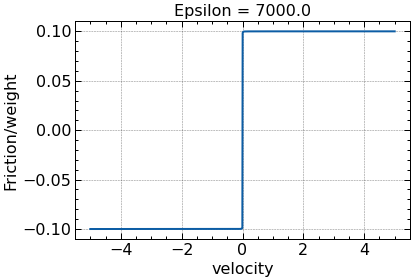

In [18]:
vel = np.linspace(-5, 5, 1000)
friction = (1/np.pi)*2*mu*np.arctan(eps*vel)
plt.plot(vel, friction)
plt.xlabel("velocity")
plt.ylabel("Friction/weight") 
plt.title(f'Epsilon = {eps}')
plt.show()

Read earthquake data and store it in a pandas dataframe

In [19]:
eq_name = 'elcentro'
file_name = eq_name + '.csv'

In [20]:
df = pd.read_csv(os.path.join(eq_name, file_name),
                index_col = 0)

Improve resolution of earthquake data by linear interpolation to a smaller timestep

In [21]:
time_step = df.index[1] - df.index[0]
t = np.arange(0, df.index[-1] + time_step, time_step)
inter = []
n = round(len(t)/len(df))

In [22]:
eq_f = interp1d(df.index,df.values.T[0], kind = 'linear')

Plot the interpolated earthquake data

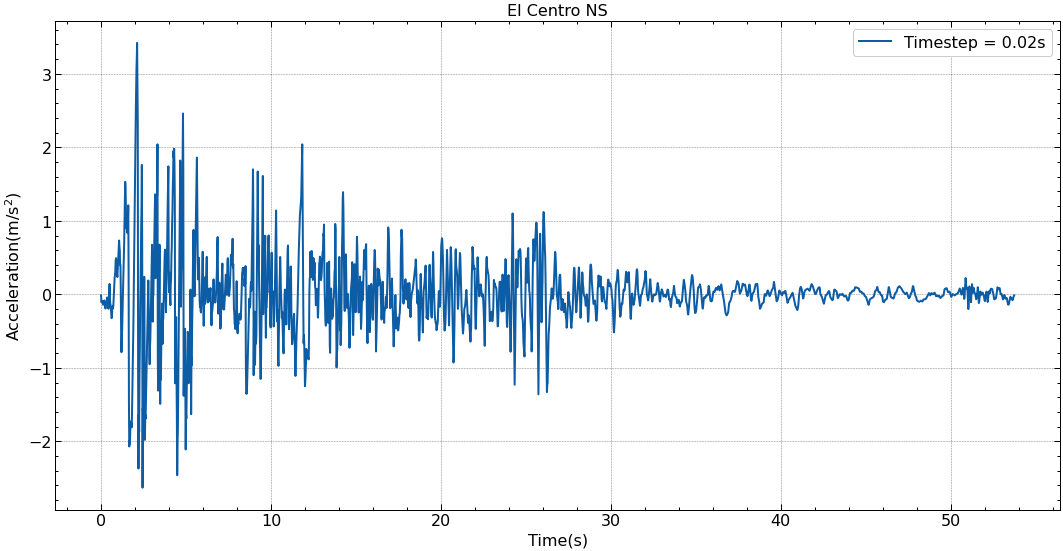

In [23]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, eq_f(t)*g)
ax.legend([h1], [f'Timestep = {time_step}s'])
ax.set_ylabel('Acceleration(m/s$^2$)')
ax.set_xlabel('Time(s)')
plt.title('El Centro NS')
plt.show()

Implement functions for soil constants based on ASCE 4-16

In [24]:
betax_f = interp1d([1.0, 1.5, 2.0, 3.0, 4.0], [0.5, 0.46, 0.46, 0.48, 0.5], kind='linear')
betaphi_f = interp1d([1.0, 1.5, 2.0, 3.0, 4.0], [0.5, 0.55, 0.6, 0.69, 0.78], kind = 'linear')

In [25]:
def soil_constants_f(B, L, poisson, shear_vel, density):
    span_ratio = L/B
    shear_modulus = shear_vel**2 * density
    kx = 2*(1+poisson)*shear_modulus*betax_f(span_ratio)*np.sqrt(B*L)
    kphi = (shear_modulus/(1-poisson))*betaphi_f(span_ratio)*B*L**2
    Rx = np.sqrt(B*L/np.pi)
    cx = 0.576*kx*Rx*np.sqrt(density/shear_modulus)
    Rphi = (B*L**3 / (3*np.pi))**0.25
    Bphi = 3*(1-poisson)*I / (8*density*Rphi**5)
    cphi = (0.3/(1+Bphi))*kphi*Rphi*np.sqrt(density/shear_modulus)
    return [kx, kphi, cx, cphi]

Define superstructure and isolator constants 

In [26]:
breadth , length , nu , vs, rho = 30.0, 70.0, 0.3, 100, 1800
mt, mb, mf, I = 2.016e6, 2.106e6, 1.008e7, 4.872e9
Ts, Tb, dampb, damps = 0.5, 2.5, 0.01, 0.05
# kt, kb, kh, kp = 1e9, 0.05e9, 1.072e9, 2.268e12
# ct, cb, ch, cp = 1.403e6, 4.712e5, 3.375e8, 2.202e11
kb = (mt + mb) * (2*np.pi/Tb) **2
cb = 2*dampb*(mt + mb)*2*np.pi/Tb
kt = mt * (2*np.pi/Ts) **2
ct = 2*dampb*mt*2*np.pi/Ts
kh, kp, ch, cp = soil_constants_f(breadth, length, nu, vs, rho)
h = 7.0
S0_init = [0,0,0,0,0,0,0,0]

In [27]:
[kt, kb, ct, cb]

[318353959.56153834,
 26036805.978425812,
 506676.06317096186,
 207194.31868955406]

Define soil constants

In [28]:
soil_constants_f(30, 70, 0.3, 100, 1800)

[1000834531.7783554,
 2381400000000.0005,
 337485095.16046655,
 220167084089.33353]

Solve the IVP for the interpolated earthquake data

In [29]:
def ground_acc_f(t):
    return eq_f(t)*g

In [30]:
def solve_eq(system, time_series, initial, earthquake):
    start, end = [time_series[0], time_series[-1]]
    ans = integrate.solve_ivp(system, (start,end), initial, method = 'BDF', t_eval = time_series, 
                              args = (earthquake,), rtol = 1e-8, atol = 1e-8)
    soln = ans.y
    dsdt = system(time_series, soln, earthquake)
    acc = np.stack((dsdt[1], dsdt[3], dsdt[5], dsdt[7]))
    return (soln, acc)

In [31]:
S0, acc = solve_eq(dSdt, t, S0_init, ground_acc_f)
# ans = integrate.solve_ivp(dSdt, (t[0],t[-1]), S0_init, method = 'BDF', t_eval = t, args = (ground_acc_f,), 
#                           rtol = 1e-8, atol = 1e-8)
# S0 = ans.y
# dsdt = dSdt(t, S0, ug_dd)
# acc = np.stack((dsdt[1], dsdt[3], dsdt[5], dsdt[7]))

In [32]:
max_value = lambda arr: abs(arr).max()

Save the solution to csv files

In [33]:
solution_arr = np.concatenate((df.values, S0.T, acc.T), axis=1)
columns = ['earthquake', 'ut', 'vt', 'ub', 'vb', 'uo', 'vo', 'phi', 'omega', 'at', 'ab', 'ao', 'alpha']

In [34]:
solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
solution_df.to_csv(os.path.join(eq_name, 'solution.csv'))
solution_df

,earthquake,ut,vt,ub,vb,uo,vo,phi,omega,at,ab,ao,alpha
Time,,,,,,,,,,,,,
0.00,-0.001428,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.014005,0.000000e+00
0.02,-0.011013,0.000001,0.000219,2.552384e-08,0.000003,0.000008,0.001000,1.138583e-11,2.849779e-09,0.028086,0.000270,0.079698,5.820170e-07
0.04,-0.010299,0.000014,0.001141,1.377567e-07,0.000008,0.000041,0.002147,3.815201e-10,4.789675e-08,0.059957,0.000164,0.038602,4.717348e-06
0.06,-0.008973,0.000050,0.002470,3.163599e-07,0.000010,0.000089,0.002606,2.782719e-09,2.200302e-07,0.069636,0.000096,0.009905,1.301717e-05
0.08,-0.009687,0.000113,0.003847,5.380925e-07,0.000012,0.000143,0.002793,1.044172e-08,5.789083e-07,0.067193,0.000114,0.008983,2.288622e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53.66,-0.007444,0.005480,0.013530,4.320098e-03,0.000021,0.000725,0.001030,-3.949026e-08,1.114055e-05,-0.129615,0.000261,0.015761,5.602352e-05
53.68,-0.005302,0.005722,0.010551,4.320572e-03,0.000026,0.000747,0.001135,1.919878e-07,1.187985e-05,-0.168223,0.000154,-0.003777,1.781651e-05
53.70,-0.003773,0.005897,0.006836,4.321108e-03,0.000028,0.000769,0.000976,4.305888e-07,1.185251e-05,-0.201642,0.000069,-0.011708,-2.048544e-05


In [35]:
drift = S0[0] - S0[2]
idr = drift / h *100
roof_acc = acc[0] + acc[2] + ground_acc_f(t)
max_idr = max_value(idr)
max_acc = max_value(roof_acc)
max_psd = max_value(S0[2])
peaks = {
    'idr': max_idr,
    'acc': max_acc,
    'psd': max_psd
}

In [36]:
peak_df = pd.DataFrame(peaks, index = ['peak'])
peak_df.to_csv(os.path.join(eq_name, 'peaks.csv'), index = None)

Plot the structural responses

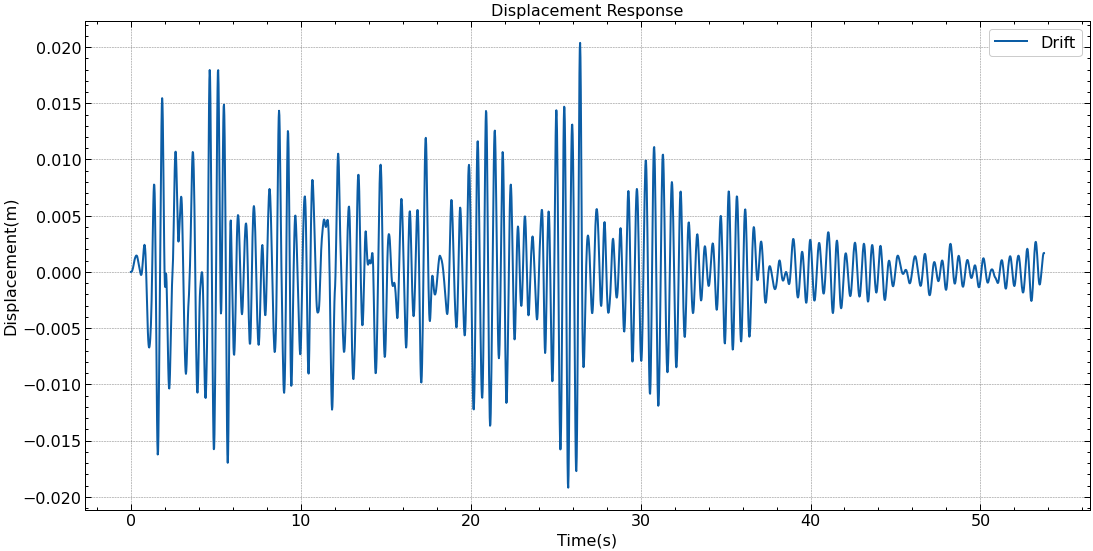

In [37]:
drift = S0[0] - S0[2]
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, drift)
ax.legend([h1, ], ['Drift', ])
ax.set_ylabel('Displacement(m)')
ax.set_xlabel('Time(s)')
plt.title('Displacement Response')
plt.show()

In [38]:
abs_drift = np.absolute(drift)
drift_max = np.amax(abs_drift) * 1000
time_max = t[np.argmax(abs_drift)]
print(f'Max drift is {drift_max} mm at {time_max}s.') 

Max drift is 20.369005917236812 mm at 26.44s.


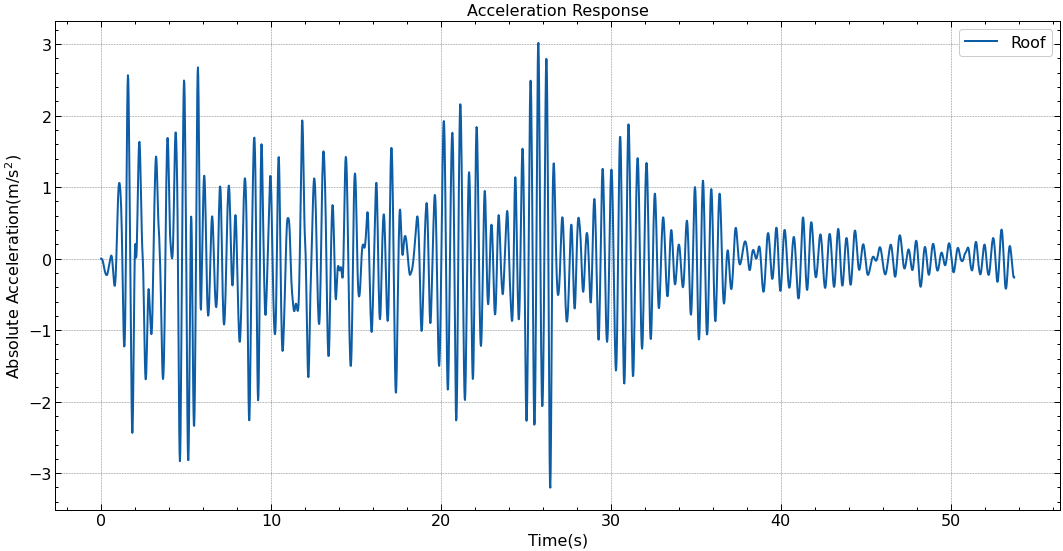

In [39]:
roof_acc = acc[0] + acc[2] + ground_acc_f(t)
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, roof_acc)
ax.legend([h1,], ['Roof',])
ax.set_xlabel('Time(s)')
ax.set_ylabel('Absolute Acceleration(m/s$^2$)')
plt.title('Acceleration Response')
plt.show()

In [40]:
abs_acc = np.absolute(roof_acc)
acc_max = np.amax(abs_acc)
time_max = t[np.argmax(abs_acc)]
print(f'Max acceleration is {acc_max} m/s\u00b2 at {time_max}s.') 

Max acceleration is 3.2031705366442402 m/s² at 26.44s.


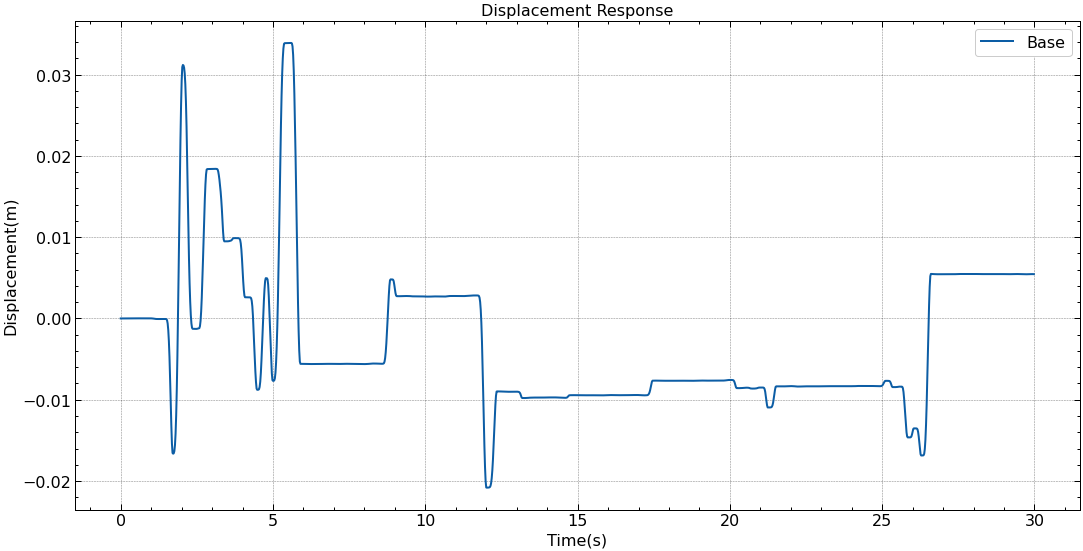

In [41]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
idx = int(30/time_step)
h2, = ax.plot(t[0:idx], S0[2][0:idx])
ax.legend([h2], ['Base'])
ax.set_ylabel('Displacement(m)')
ax.set_xlabel('Time(s)')
plt.title('Displacement Response')
plt.show()

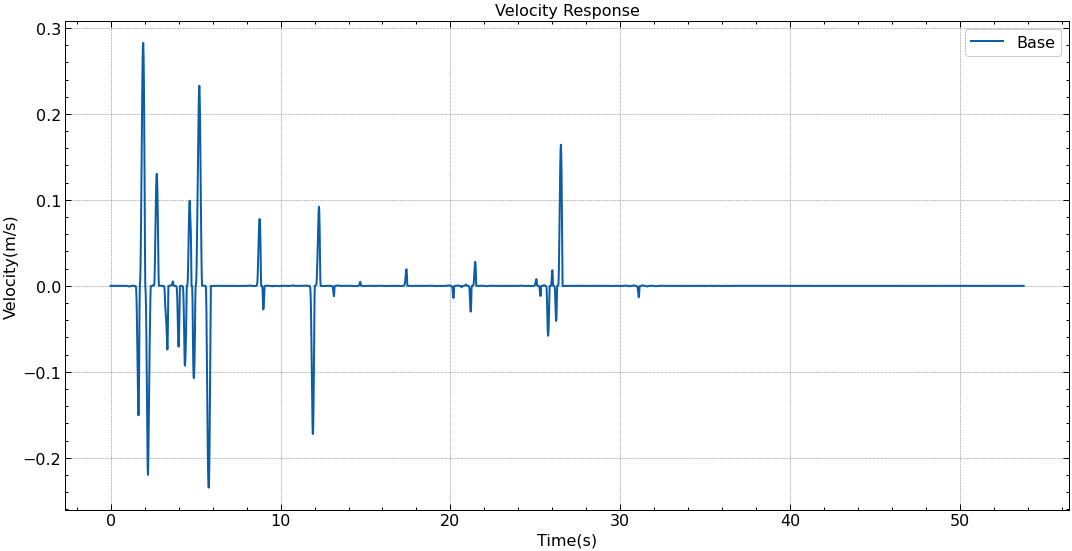

In [42]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h2, = ax.plot(t, S0[3])
ax.legend([h2], ['Base'])
ax.set_ylabel('Velocity(m/s)')
ax.set_xlabel('Time(s)')
plt.title('Velocity Response')
plt.show()

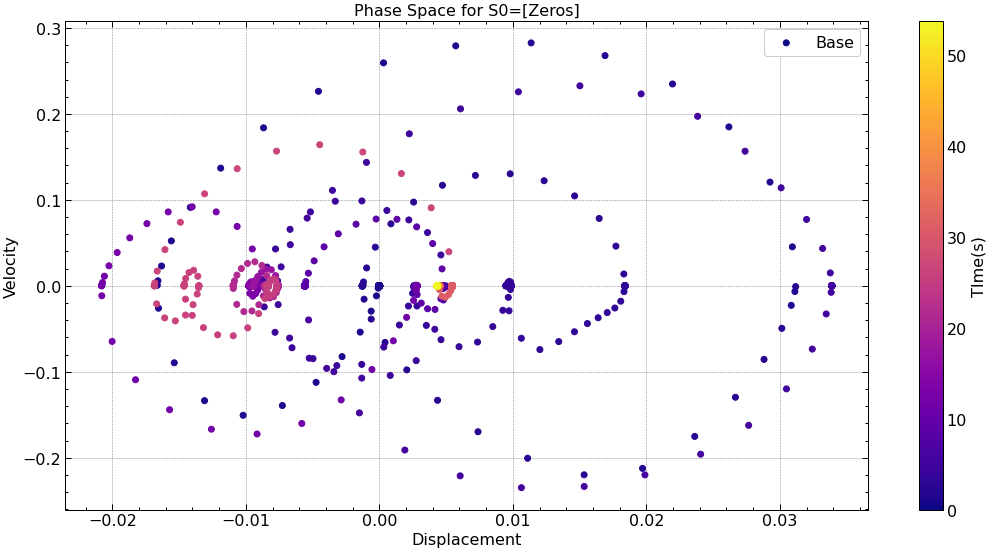

In [43]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1 = ax.scatter(S0[2], S0[3], c = t, cmap = 'plasma')
# ax.plot(S0[2], S0[3])
ax.legend([h1, ], ['Base', ])
ax.set_ylabel('Velocity')
ax.set_xlabel('Displacement')
plt.title('Phase Space for S0=[Zeros]')
plt.colorbar(h1, label = 'TIme(s)')
plt.show()

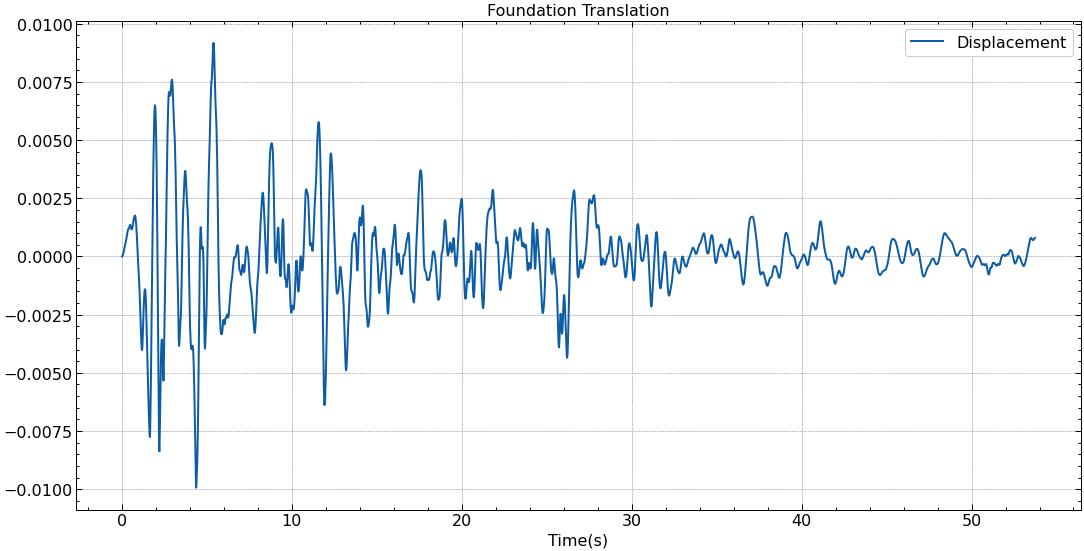

In [44]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, S0[4])
ax.legend([h1, ], ['Displacement', ])
ax.set_xlabel('Time(s)')
plt.title('Foundation Translation')
plt.show()

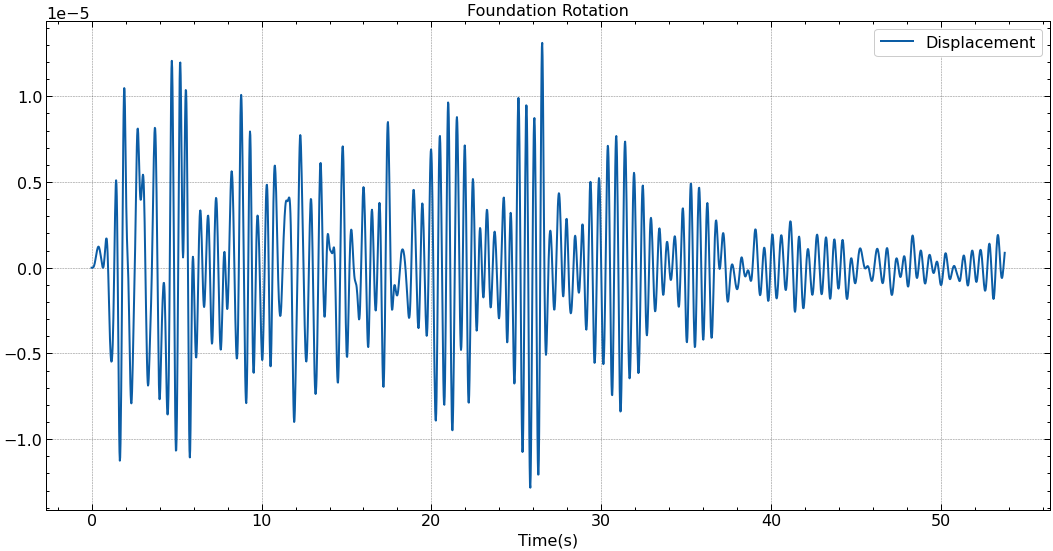

In [45]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, S0[6])
ax.legend([h1,], ['Displacement',])
ax.set_xlabel('Time(s)')
plt.title('Foundation Rotation')
plt.show()

## Scaling

In [46]:
max_value(eq_f(t))

0.34873739

In [47]:
solutions = np.zeros(shape = (10, 8, len(df)))
accels = np.zeros(shape = (10, 4, len(df)))
eq_scaled = np.zeros(shape = (10, 1, len(df)))
max_drifts = np.zeros(10)
max_accels = np.zeros(10)
max_disps = np.zeros(10)

In [48]:
eq_data = eq_f(t) 
for i in range(10):
    eqs = eq_data/max_value(eq_data)*(i+1)/10
    eq_interp = interp1d(t, eqs, kind = 'linear')
    eqs_f = lambda t: eq_interp(t) * g
    solutions[i], accels[i] = solve_eq(dSdt, t, S0_init, eqs_f)
    eq_scaled[i] = eqs
    max_drifts[i] = max_value(solutions[i,0] - solutions[i,2])
    max_accels[i] = max_value(accels[i,0] + accels[i,2] + eqs*g)
    max_disps[i] = max_value(solutions[i,2])

In [49]:
eq_scaled[9,0,250]/df.values[250]

array([2.86748719])

In [50]:
factors = np.arange(0.1, 1.1, 0.1).round(1)
factors

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [51]:
np.shape(solutions[0])

(8, 2688)

In [52]:
for i,v in enumerate(factors):
    directory = os.path.join(eq_name, str(v))
    if not os.path.exists(directory):
        os.mkdir(directory)
    solution_arr = np.concatenate((eq_scaled[i].T, solutions[i].T, accels[i].T), axis=1)
    columns = ['earthquake', 'ut', 'vt', 'ub', 'vb', 'uo', 'vo', 'phi', 'omega', 'at', 'ab', 'ao', 'alpha']
    solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
    solution_df.to_csv(os.path.join(directory, 'solution.csv'))
    peaks = {'idr': max_drifts[i]/h*100, 'acc': max_accels[i], 'psd': max_disps[i]}
    peak_df = pd.DataFrame(peaks, index = ['peak'])
    peak_df.to_csv(os.path.join(directory, 'peaks.csv'), index = None)

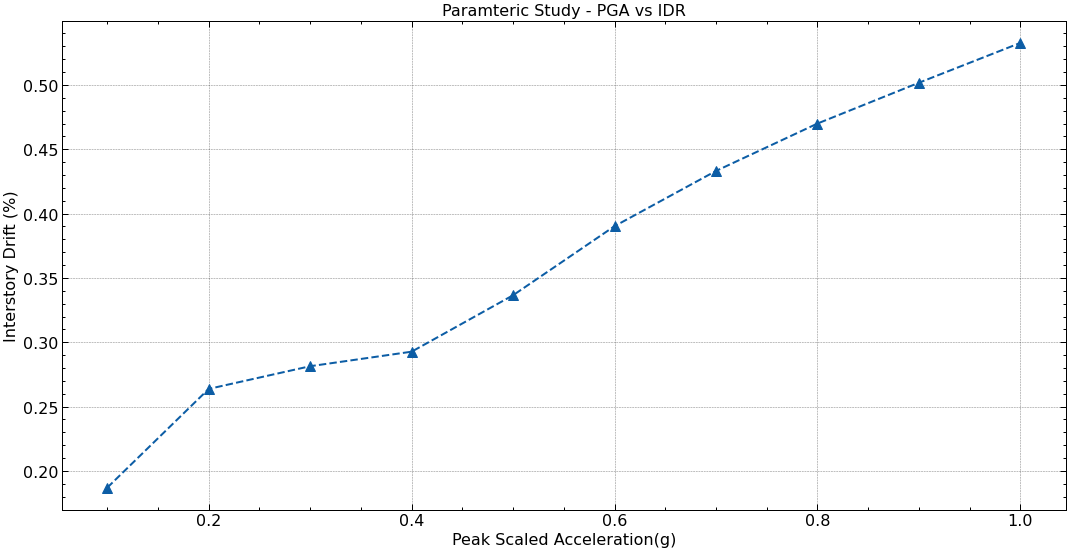

In [53]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1 = ax.plot(factors, max_drifts/h*100, '^--', ms = 10.0)
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Interstory Drift (%)')
plt.title('Paramteric Study - PGA vs IDR')
plt.show()

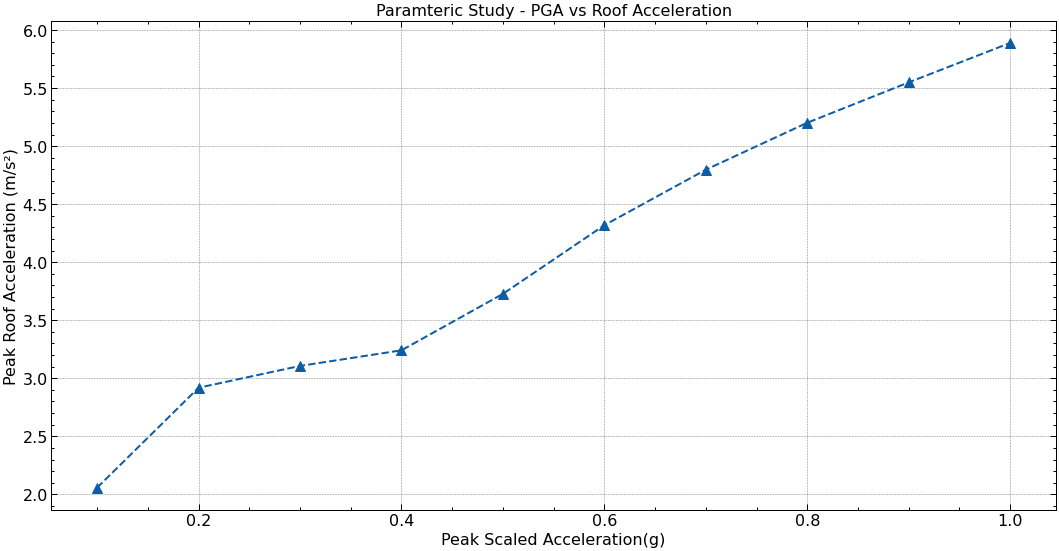

In [54]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1 = ax.plot(factors, max_accels, '^--', ms = 10.0)
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Peak Roof Acceleration (m/s\u00b2)')
plt.title('Paramteric Study - PGA vs Roof Acceleration')
plt.show()

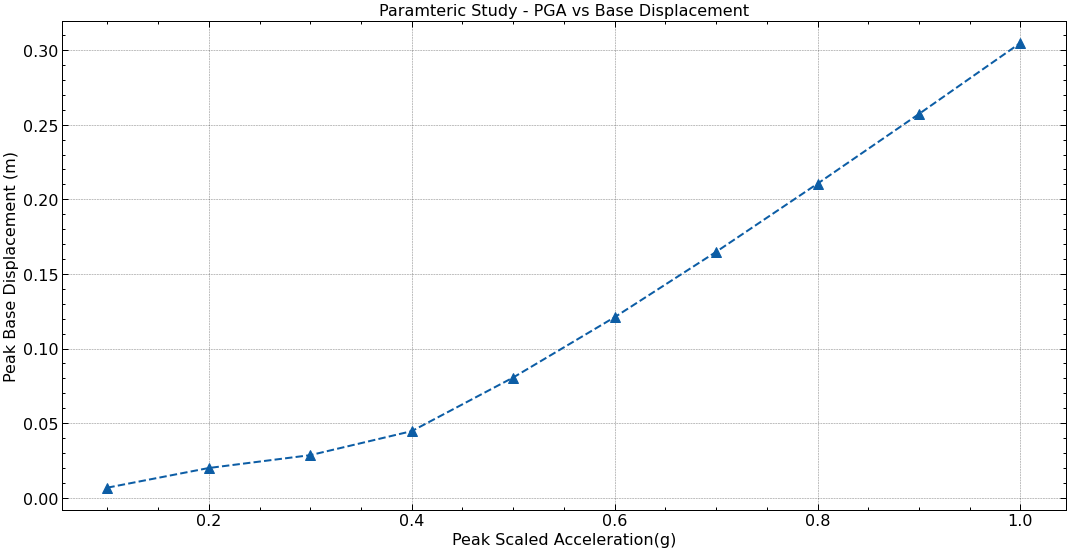

In [55]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1 = ax.plot(factors, max_disps, '^--', ms = 10.0)
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Peak Base Displacement (m)')
plt.title('Paramteric Study - PGA vs Base Displacement')
plt.show()

## Fixed Base

Find the response for fixed base building by assuming $\mu = 1000$. Construct a state-space vector $S1$ similar to $S0$

In [56]:
mu = 1000
S1_init = [0,0,0,0,0,0,0,0]

In [57]:
S1, acc1 = solve_eq(dSdt, t, S1_init, ground_acc_f)

Save the solution to csv

In [58]:
solution_arr = np.concatenate((df.values, S1.T, acc1.T), axis=1)
solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
solution_df.to_csv(os.path.join(eq_name, 'solution_fixed_base.csv'))

In [59]:
drift_fix = S1[0] - S1[2]
idr_fix = drift_fix / h *100
roof_acc_fix = acc1[0] + acc1[2] + ground_acc_f(t)
max_idr = max_value(idr_fix)
max_acc = max_value(roof_acc_fix)
max_psd = max_value(S1[2])
peaks = {
    'idr': max_idr,
    'acc': max_acc,
    'psd': max_psd
}

In [60]:
peak_df = pd.DataFrame(peaks, index = ['peak'])
peak_df.to_csv(os.path.join(eq_name, 'peaks_fixed_base.csv'), index = None)

Plot the response of fixed base building and compare it with base isolated building

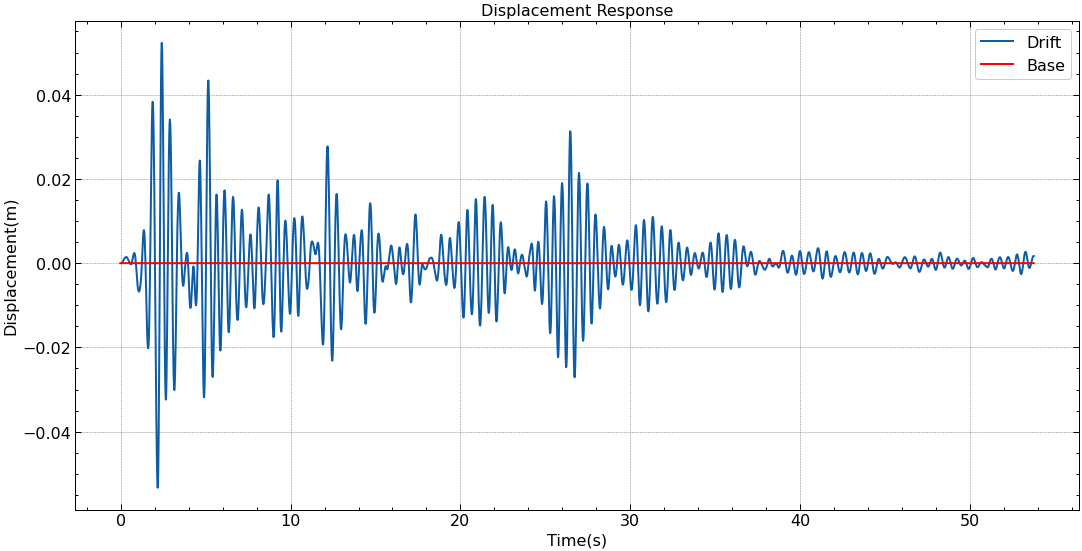

In [61]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, drift_fix)
h2, = ax.plot(t, S1[2], color = 'red')
ax.legend([h1, h2], ['Drift', 'Base'])
ax.set_ylabel('Displacement(m)')
ax.set_xlabel('Time(s)')
plt.title('Displacement Response')
plt.show()

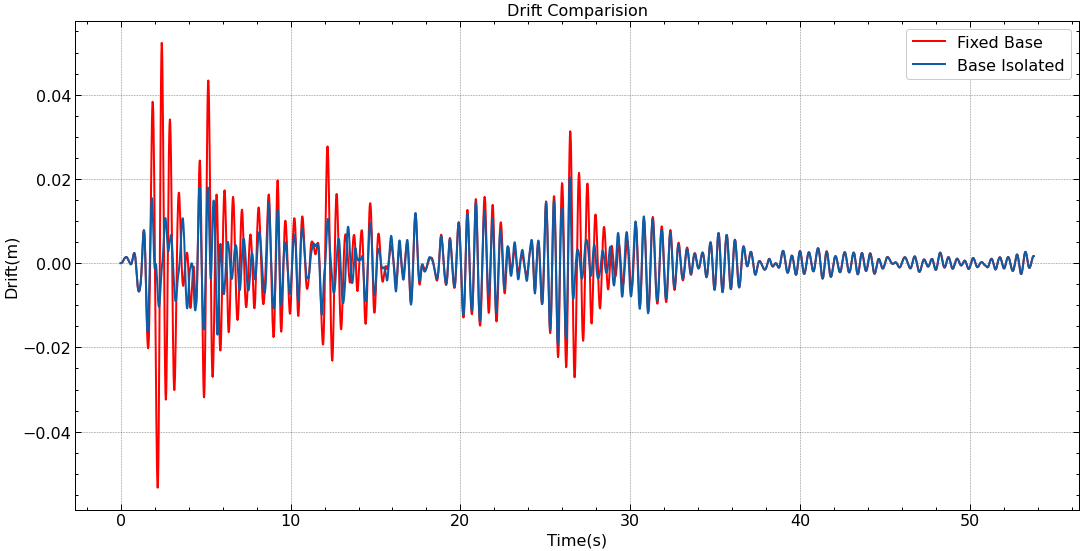

In [62]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, drift_fix, color = 'red')
h2, = ax.plot(t, drift)
ax.legend([h1, h2], ['Fixed Base', 'Base Isolated'])
ax.set_ylabel('Drift(m)')
ax.set_xlabel('Time(s)')
plt.title('Drift Comparision')
plt.show()

In [63]:
abs_drift_fix = np.absolute(drift_fix)
drift_max_fix = np.amax(abs_drift_fix) * 1000
time_max = t[np.argmax(abs_drift_fix)]
reduce = (drift_max_fix - drift_max)/drift_max_fix * 100
print(f'Max drift is {drift_max_fix} mm at {time_max}s. {reduce:.2f}% reduction of max drift is observed')

Max drift is 53.29586709297141 mm at 2.18s. 61.78% reduction of max drift is observed


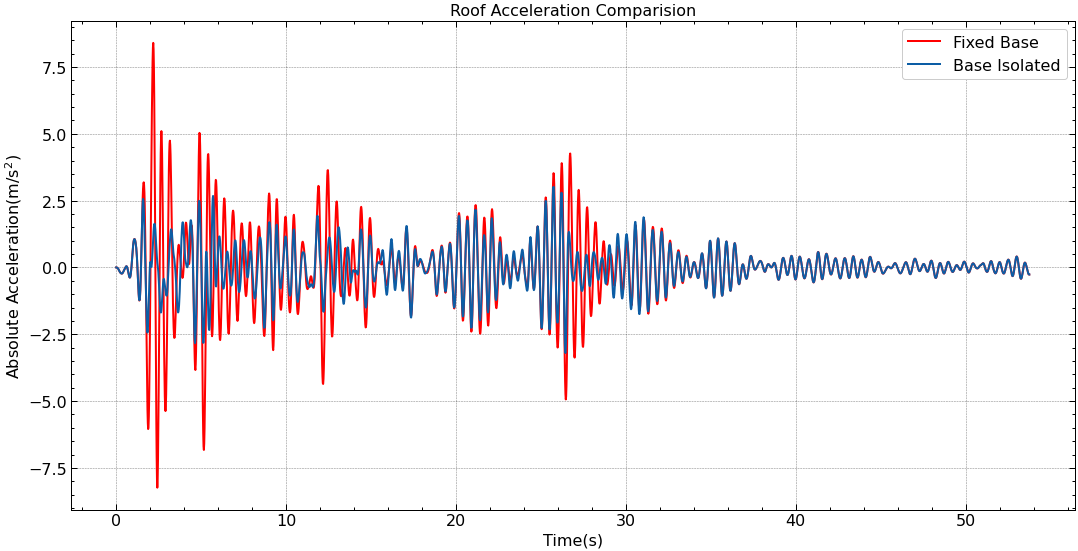

In [64]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, roof_acc_fix, color = 'red')
h2, = ax.plot(t, roof_acc)
ax.legend([h1, h2], ['Fixed Base', 'Base Isolated'])
ax.set_ylabel('Absolute Acceleration(m/s$^2$)')
ax.set_xlabel('Time(s)')
plt.title('Roof Acceleration Comparision')
plt.show()

In [65]:
abs_acc_fix = np.absolute(roof_acc_fix)
acc_max_fix = np.amax(abs_acc_fix)
time_max = t[np.argmax(abs_acc_fix)]
reduce = (acc_max_fix - acc_max)/acc_max_fix * 100
print(f'Max acceleration is {acc_max_fix} m/s\u00b2 at {time_max}s. {reduce:.2f}% reduction of max acceleration is observed') 

Max acceleration is 8.401868473093451 m/s² at 2.18s. 61.88% reduction of max acceleration is observed


Save solutions to csv after scaling

In [66]:
solutions1 = np.zeros(shape = (10, 8, len(df)))
accels1 = np.zeros(shape = (10, 4, len(df)))
eq_scaled1 = np.zeros(shape = (10, 1, len(df)))
max_drifts1 = np.zeros(10)
max_accels1 = np.zeros(10)
max_disps1 = np.zeros(10)

In [67]:
eq_data = eq_f(t) 
for i in range(10):
    eqs = eq_data/max_value(eq_data)*(i+1)/10
    eq_interp = interp1d(t, eqs, kind = 'linear')
    eqs_f = lambda t: eq_interp(t) * g
    solutions1[i], accels1[i] = solve_eq(dSdt, t, S1_init, eqs_f)
    eq_scaled1[i] = eqs
    max_drifts1[i] = max_value(solutions1[i,0] - solutions1[i,2])
    max_accels1[i] = max_value(accels1[i,0] + accels1[i,2] + eqs*g)
    max_disps1[i] = max_value(solutions1[i,2])

In [68]:
for i,v in enumerate(factors):
    directory = os.path.join(eq_name, str(v))
    if not os.path.exists(directory):
        os.mkdir(directory)
    solution_arr = np.concatenate((eq_scaled1[i].T, solutions1[i].T, accels1[i].T), axis=1)
    columns = ['earthquake', 'ut', 'vt', 'ub', 'vb', 'uo', 'vo', 'phi', 'omega', 'at', 'ab', 'ao', 'alpha']
    solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
    solution_df.to_csv(os.path.join(directory, 'solution_fixed_base.csv'))
    peaks = {'idr': max_drifts1[i]/h*100, 'acc': max_accels1[i], 'psd': max_disps1[i]}
    peak_df = pd.DataFrame(peaks, index = ['peak'])
    peak_df.to_csv(os.path.join(directory, 'peaks_fixed_base.csv'), index = None)

Plot the parametric curves

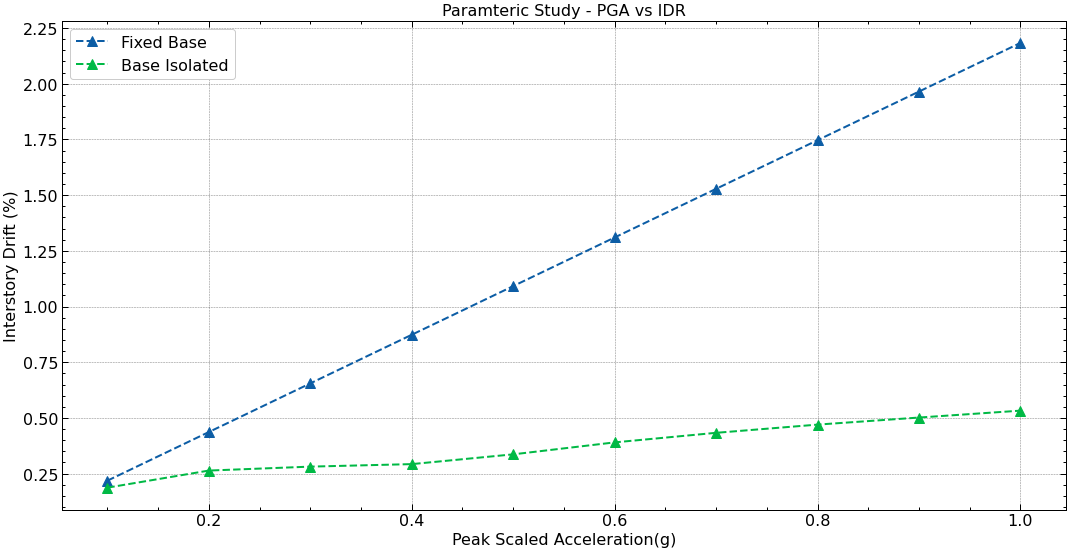

In [69]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(factors, max_drifts1/h*100, '^--', ms = 10.0)
h2, = ax.plot(factors, max_drifts/h*100, '^--', ms = 10.0)
ax.legend([h1, h2], ['Fixed Base', 'Base Isolated'])
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Interstory Drift (%)')
plt.title('Paramteric Study - PGA vs IDR')
plt.show()

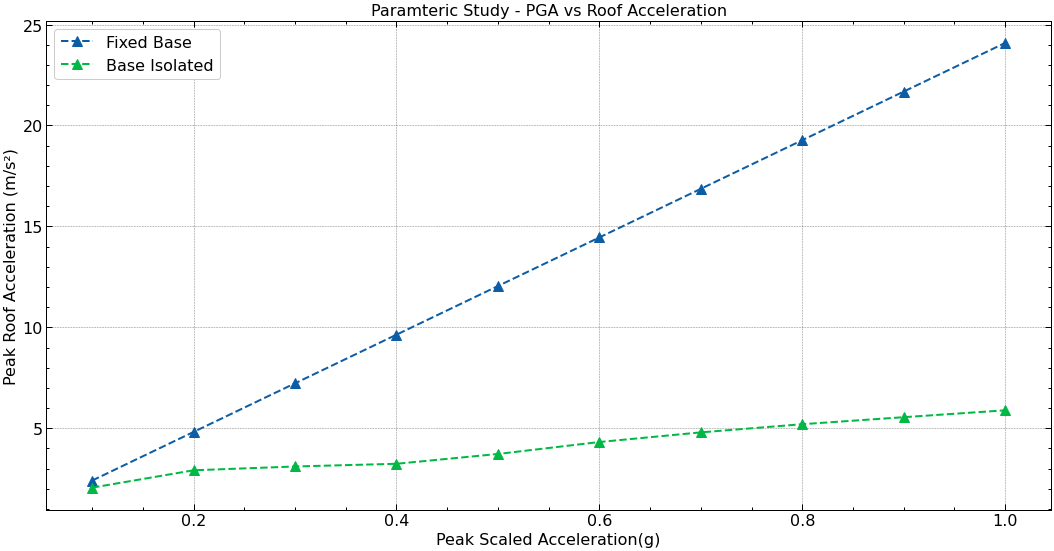

In [70]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(factors, max_accels1, '^--', ms = 10.0)
h2, = ax.plot(factors, max_accels, '^--', ms = 10.0)
ax.legend([h1, h2], ['Fixed Base', 'Base Isolated'])
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Peak Roof Acceleration (m/s\u00b2)')
plt.title('Paramteric Study - PGA vs Roof Acceleration')
plt.show()

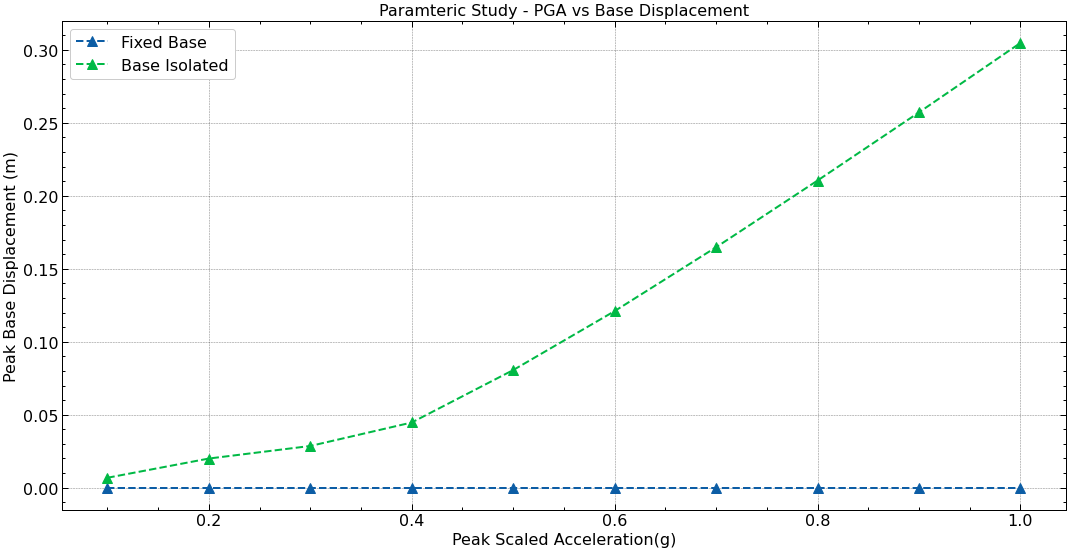

In [71]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(factors, max_disps1, '^--', ms = 10.0)
h2, = ax.plot(factors, max_disps, '^--', ms = 10.0)
ax.legend([h1, h2], ['Fixed Base', 'Base Isolated'])
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Peak Base Displacement (m)')
plt.title('Paramteric Study - PGA vs Base Displacement')
plt.show()

## Without SSI

In [72]:
mu = 0.1
S2_init = [0,0,0,0,0,0,0,0]
vs = 5500
kh, kp, ch, cp = soil_constants_f(breadth, length, nu, vs, rho)

In [73]:
kh, kp, ch, cp

(3027524458629.525, 7203735000000001.0, 18561680233.825657, 12109189624913.344)

In [74]:
S2, acc2 = solve_eq(dSdt, t, S2_init, ground_acc_f)

Save solution to csv

In [75]:
solution_arr = np.concatenate((df.values, S2.T, acc2.T), axis=1)
solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
solution_df.to_csv(os.path.join(eq_name, 'solution_no_ssi.csv'))

In [76]:
drift_ssi = S2[0] - S2[2]
idr_ssi = drift_ssi / h *100
roof_acc_ssi = acc2[0] + acc2[2] + ground_acc_f(t)
max_idr = max_value(idr_ssi)
max_acc = max_value(roof_acc_ssi)
max_psd = max_value(S2[2])
peaks = {
    'idr': max_idr,
    'acc': max_acc,
    'psd': max_psd
}

In [77]:
peak_df = pd.DataFrame(peaks, index = ['peak'])
peak_df.to_csv(os.path.join(eq_name, 'peaks_no_ssi.csv'), index = None)

Plot the responses and compare it to response with SSI

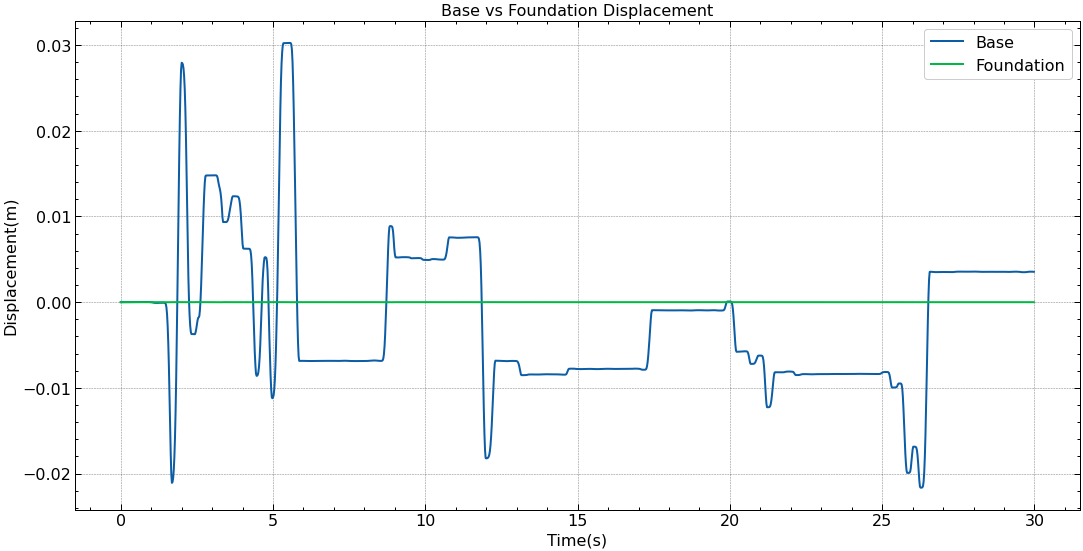

In [78]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
idx = int(30/time_step)
h1, = ax.plot(t[0:idx], S2[2][0:idx])
h2, = ax.plot(t[0:idx], S2[4][0:idx])
ax.legend([h1, h2], ['Base', 'Foundation'])
ax.set_xlabel('Time(s)')
ax.set_ylabel('Displacement(m)')
plt.title('Base vs Foundation Displacement')
plt.show()

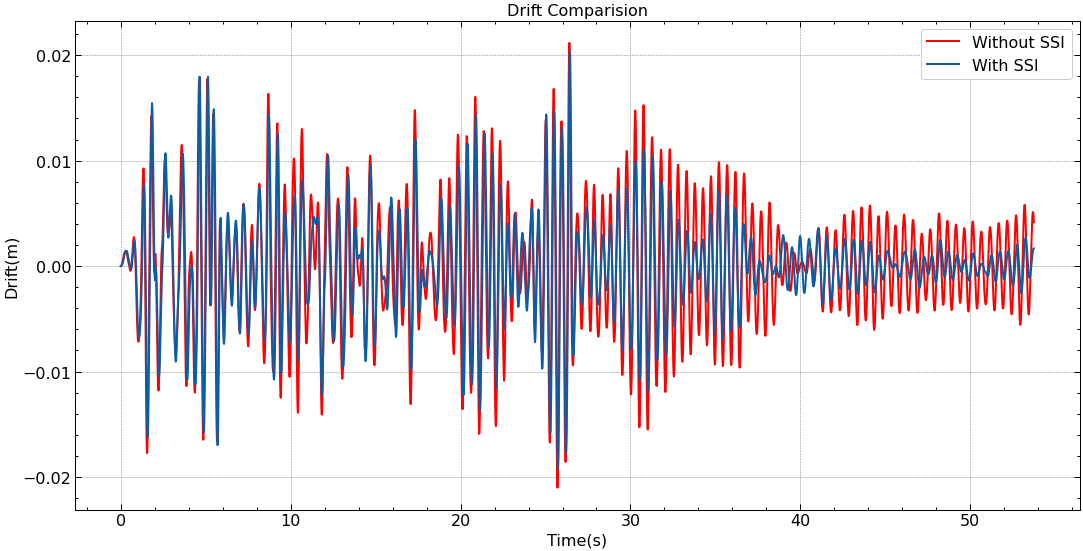

In [79]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, drift_ssi, color = 'red')
h2, = ax.plot(t, drift)
ax.legend([h1, h2], ['Without SSI', 'With SSI'])
ax.set_ylabel('Drift(m)')
ax.set_xlabel('Time(s)')
plt.title('Drift Comparision')
plt.show()

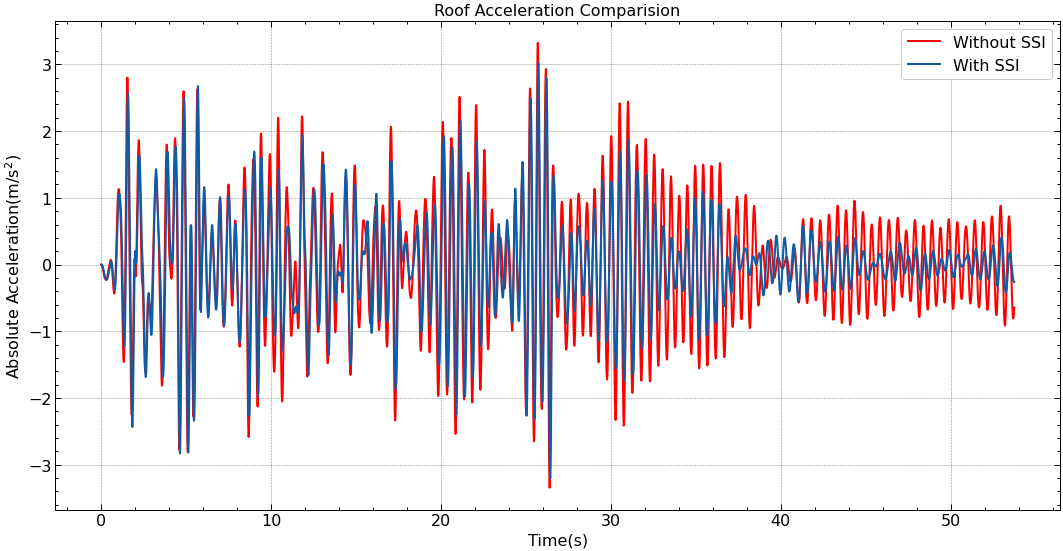

In [80]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, roof_acc_ssi, color = 'red')
h2, = ax.plot(t, roof_acc)
ax.legend([h1, h2], ['Without SSI', 'With SSI'])
ax.set_ylabel('Absolute Acceleration(m/s$^2$)')
ax.set_xlabel('Time(s)')
plt.title('Roof Acceleration Comparision')
plt.show()

Save solutions to csv after scaling

In [81]:
solutions2 = np.zeros(shape = (10, 8, len(df)))
accels2 = np.zeros(shape = (10, 4, len(df)))
eq_scaled2 = np.zeros(shape = (10, 1, len(df)))
max_drifts2 = np.zeros(10)
max_accels2 = np.zeros(10)
max_disps2 = np.zeros(10)

In [82]:
eq_data = eq_f(t) 
for i in range(10):
    eqs = eq_data/max_value(eq_data)*(i+1)/10
    eq_interp = interp1d(t, eqs, kind = 'linear')
    eqs_f = lambda t: eq_interp(t) * g
    solutions2[i], accels2[i] = solve_eq(dSdt, t, S1_init, eqs_f)
    eq_scaled2[i] = eqs
    max_drifts2[i] = max_value(solutions2[i,0] - solutions2[i,2])
    max_accels2[i] = max_value(accels2[i,0] + accels2[i,2] + eqs*g)
    max_disps2[i] = max_value(solutions2[i,2])

In [83]:
for i,v in enumerate(factors):
    directory = os.path.join(eq_name, str(v))
    if not os.path.exists(directory):
        os.mkdir(directory)
    solution_arr = np.concatenate((eq_scaled2[i].T, solutions2[i].T, accels2[i].T), axis=1)
    columns = ['earthquake', 'ut', 'vt', 'ub', 'vb', 'uo', 'vo', 'phi', 'omega', 'at', 'ab', 'ao', 'alpha']
    solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
    solution_df.to_csv(os.path.join(directory, 'solution_no_ssi.csv'))
    peaks = {'idr': max_drifts2[i]/h*100, 'acc': max_accels2[i], 'psd': max_disps2[i]}
    peak_df = pd.DataFrame(peaks, index = ['peak'])
    peak_df.to_csv(os.path.join(directory, 'peaks_no_ssi.csv'), index = None)

Plot the parametric curves

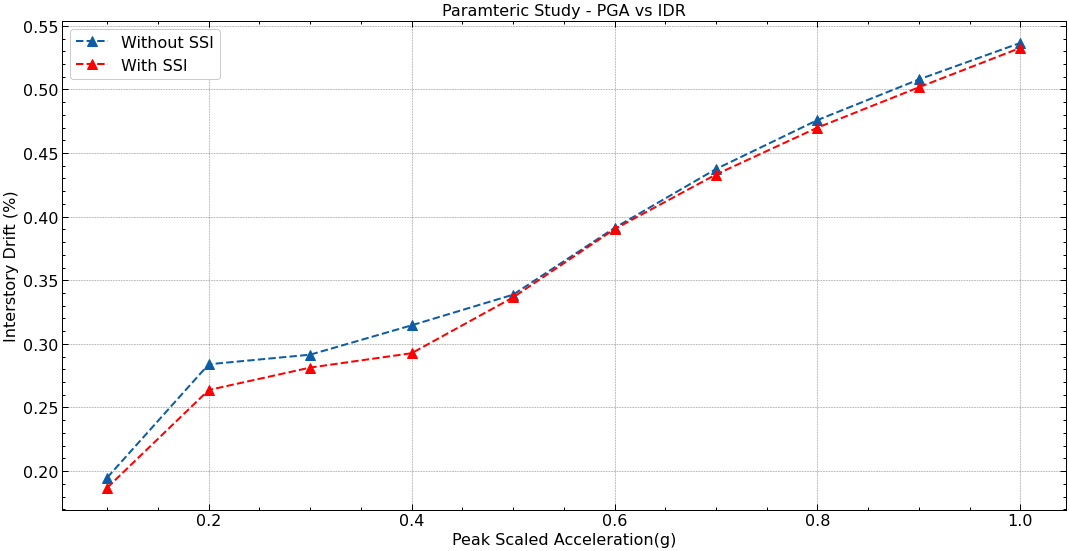

In [84]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(factors, max_drifts2/h*100, '^--', ms = 10.0)
h2, = ax.plot(factors, max_drifts/h*100, 'r^--', ms = 10.0)
ax.legend([h1, h2], ['Without SSI', 'With SSI'])
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Interstory Drift (%)')
plt.title('Paramteric Study - PGA vs IDR')
plt.show()

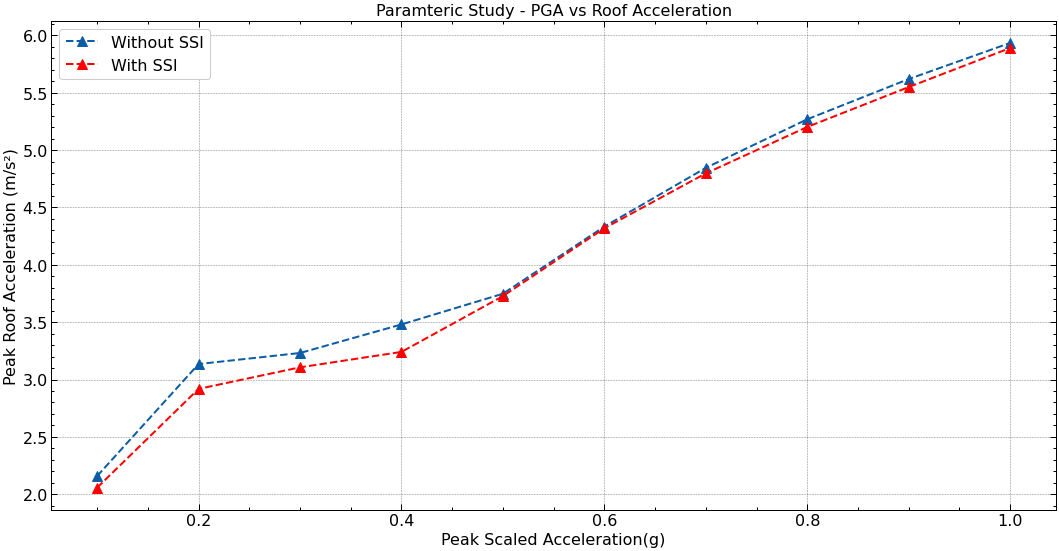

In [85]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(factors, max_accels2, '^--', ms = 10.0)
h2, = ax.plot(factors, max_accels, 'r^--', ms = 10.0)
ax.legend([h1, h2], ['Without SSI', 'With SSI'])
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Peak Roof Acceleration (m/s\u00b2)')
plt.title('Paramteric Study - PGA vs Roof Acceleration')
plt.show()

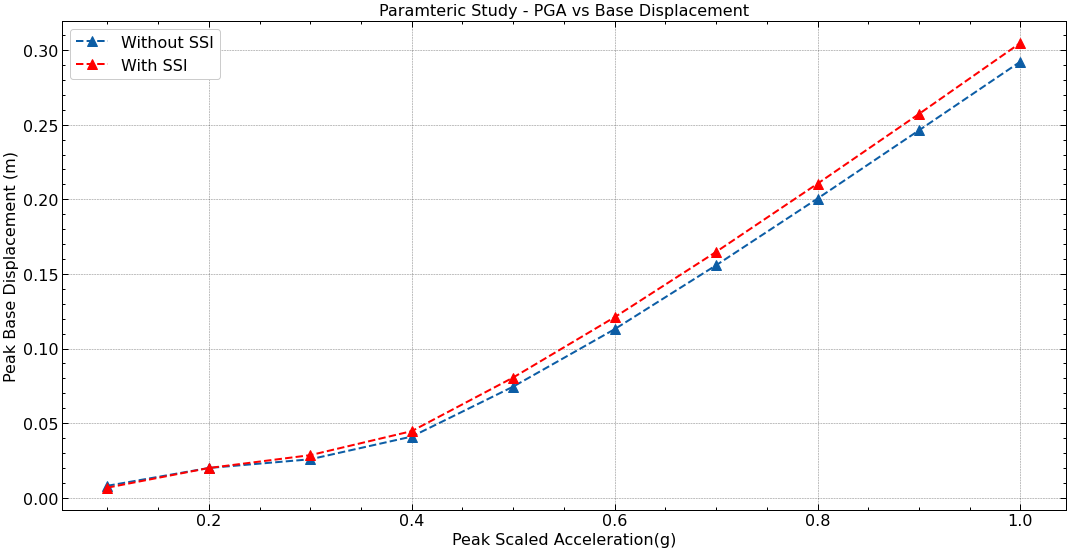

In [86]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(factors, max_disps2, '^--', ms = 10.0)
h2, = ax.plot(factors, max_disps, 'r^--', ms = 10.0)
ax.legend([h1, h2], ['Without SSI', 'With SSI'])
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Peak Base Displacement (m)')
plt.title('Paramteric Study - PGA vs Base Displacement')
plt.show()

## Parametric Study against Shear Wave Velocity

In [123]:
velocities = (50, 100, 150, 200, 250, 300, 350, 400)

In [124]:
solutions = np.zeros(shape = (8, 8, len(df)))
accels = np.zeros(shape = (8, 4, len(df)))
max_drifts = np.zeros(8)
max_accels = np.zeros(8)
max_disps = np.zeros(8)

In [125]:
for i in range(8):
    vs = velocities[i]
    kh, kp, ch, cp = soil_constants_f(breadth, length, nu, vs, rho)
    solutions[i], accels[i] = solve_eq(dSdt, t, S0_init, ground_acc_f)
    max_drifts[i] = max_value(solutions[i,0] - solutions[i,2])
    max_accels[i] = max_value(accels[i,0] + accels[i,2] + ground_acc_f(t))
    max_disps[i] = max_value(solutions[i,2])

In [128]:
shear_wave_folder = os.path.join(eq_name, 'shear_wave_velocities')
if not os.path.exists(shear_wave_folder):
        os.mkdir(shear_wave_folder)
for i, v in enumerate(velocities):
    directory = os.path.join(eq_name, 'shear_wave_velocities', str(v))
    if not os.path.exists(directory):
        os.mkdir(directory)
    solution_arr = np.concatenate((df.values, solutions[i].T, accels[i].T), axis=1)
    columns = ['earthquake', 'ut', 'vt', 'ub', 'vb', 'uo', 'vo', 'phi', 'omega', 'at', 'ab', 'ao', 'alpha']
    solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
    solution_df.to_csv(os.path.join(directory, 'solution.csv'))
    peaks = {'idr': max_drifts[i]/h*100, 'acc': max_accels[i], 'psd': max_disps[i]}
    peak_df = pd.DataFrame(peaks, index = ['peak'])
    peak_df.to_csv(os.path.join(directory, 'peaks.csv'), index = None)

Plot the parametric curves

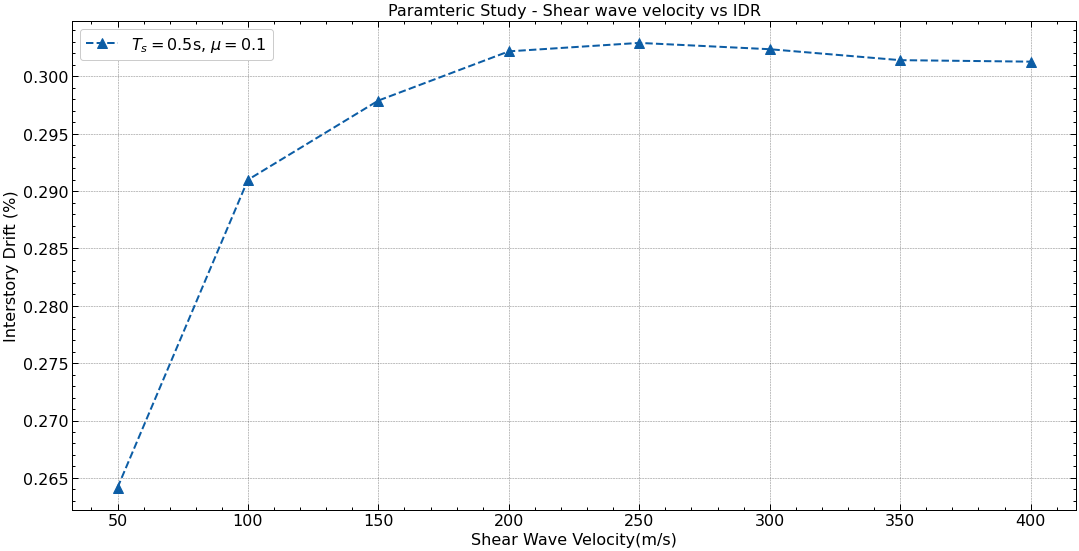

In [134]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(velocities, max_drifts/h*100, '^--', ms = 10.0)
ax.legend([h1, ], ['$T_s = 0.5$s, $\mu = 0.1$'])
ax.set_xlabel('Shear Wave Velocity(m/s)')
ax.set_ylabel('Interstory Drift (%)')
plt.title('Paramteric Study - Shear wave velocity vs IDR')
plt.show()

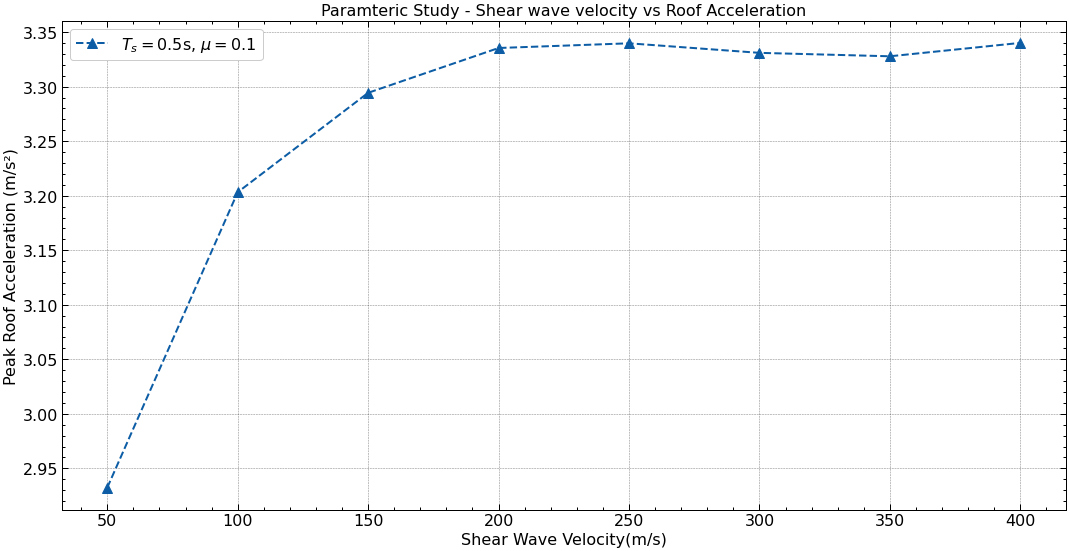

In [135]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(velocities, max_accels, '^--', ms = 10.0)
ax.legend([h1, ], ['$T_s = 0.5$s, $\mu = 0.1$'])
ax.set_xlabel('Shear Wave Velocity(m/s)')
ax.set_ylabel('Peak Roof Acceleration (m/s\u00b2)')
plt.title('Paramteric Study - Shear wave velocity vs Roof Acceleration')
plt.show()

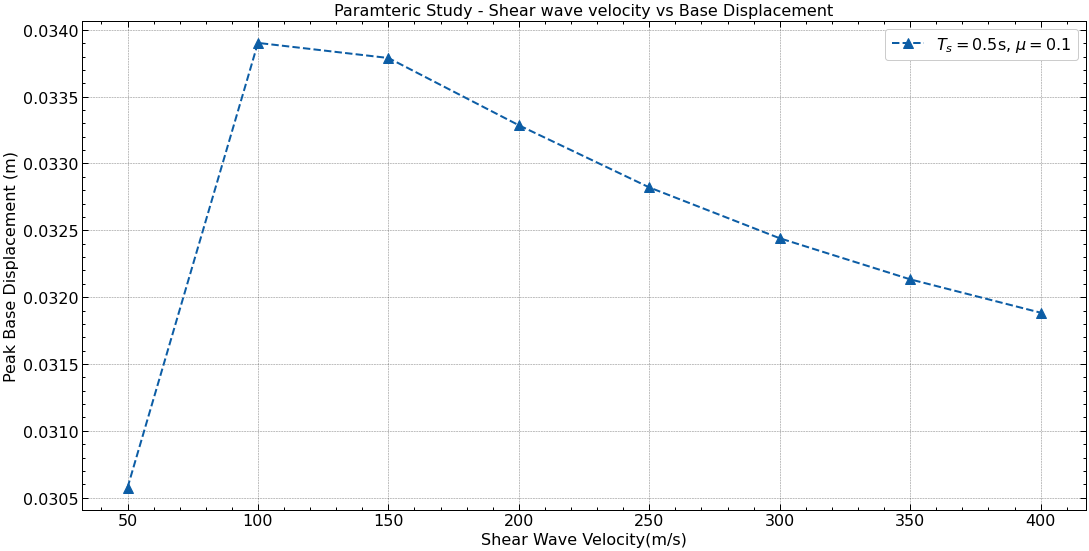

In [136]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(velocities, max_disps, '^--', ms = 10.0)
ax.legend([h1, ], ['$T_s = 0.5$s, $\mu = 0.1$'])
ax.set_xlabel('Shear Wave Velocity(m/s)')
ax.set_ylabel('Peak Base Displacement (m)')
plt.title('Paramteric Study - Shear wave velocity vs Base Displacement')
plt.show()